In [5]:
from __future__ import print_function

from miscc.utils import mkdir_p
from miscc.utils import build_super_images
from miscc.losses import sent_loss, words_loss
from miscc.config import cfg, cfg_from_file

from datasets import TextDataset
from datasets import prepare_data

from model import TEXT_TRANSFORMER_ENCODERv2, CNN_ENCODER

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
    
import argparse
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import PositionalEmbedding as PE
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import transforms

from catr.models import caption
from catr.models import utils as mtils
from catr.datasets import coco, utils
from catr.cfg_damsm_cub import Config
from transformers import BertTokenizer

# dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
# sys.path.append(dir_path)

In [6]:
berttk = BertTokenizer.from_pretrained("bert-base-uncased", do_lower=True)
cocotk = BertTokenizer.from_pretrained("catr/damsm_vocab.txt", do_lower=True)
birdtk = BertTokenizer.from_pretrained("catr/bird_vocab.txt", do_lower=True)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


## Visualize COCO2014 data

In [52]:
cfg_from_file('cfg/coco_multimodal.yml')
from catr.cfg_damsm_bert import Config
config = Config()
#### train set ####
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
batch_size = cfg.TRAIN.BATCH_SIZE
image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, 'train',
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform, 
                      max_length=128, 
                      vocab=config.vocab)
print(dataset.n_words, dataset.embeddings_num)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, drop_last=True,
    shuffle=True, num_workers=0)
#### val set ####
dataset_val = TextDataset(cfg.DATA_DIR, 'test',
                          base_size=cfg.TREE.BASE_SIZE,
                          transform=image_transform,
                          max_length=128, 
                          vocab=config.vocab)
val_batch_size = 32
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=val_batch_size, drop_last=True,
    shuffle=False, num_workers=0)
print(dataset_val.n_words, dataset_val.embeddings_num)

Load filenames from: ../data/coco/train/filenames.pickle (82783)
Load filenames from: ../data/coco/test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/train
27297 5
Load filenames from: ../data/coco/train/filenames.pickle (82783)
Load filenames from: ../data/coco/test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/test
27297 5


In [70]:
it = iter(dataloader_val)

In [71]:
dt = it.next()

In [72]:
im, a, b, c, d, c1, c2, c3, c4 = prepare_data(dt)

In [73]:
print(im[0].shape)
print(a.shape)
print(b.shape)
print(c.shape)
print(len(d))
print(c1.shape)
print(c2.shape)
print(c3.shape)
print(c4.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32, 15])
torch.Size([32])
(32,)
32
torch.Size([32, 3, 299, 299])
torch.Size([32, 299, 299])
torch.Size([32, 129])
torch.Size([32, 129])


tensor([   8,  478,    7,   10,  518, 3533,   58,  426,  115, 3725,   10,  489,
           0,    0,    0], device='cuda:0')
tensor([  101,  1996, 23801,  1999,  1037,  2304,  3933,  1998,  6045,  2003,
        15497,  1037,  6510,   102], device='cuda:0')
the batter in a black jersey and hat is awaiting a pitch
the batter in a black jersey and hat is awaiting a pitch


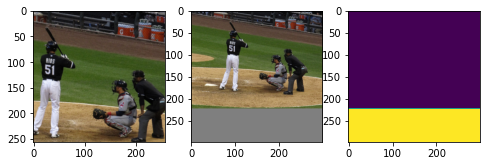

In [77]:
import matplotlib.pyplot as plt
i = 3
cap0 = a[i]
cap = c3[i]
cap_m = c4[i]
print(cap0)
print(cap[~cap_m])
print(berttk.decode(cap, skip_special_tokens=True))
print(cocotk.decode(cap0, skip_special_tokens=True))

img = c1[i].cpu()
mask = c2[i].cpu()
img0 = im[2][i].cpu()
# print(img[i].min(), img[i].max())
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,3,1)
plt.imshow((img0.numpy().transpose((1,2,0)) - img0.min().numpy()) / (img0.max() - img0.min()).numpy())
fig.add_subplot(1,3,2)
plt.imshow((img.numpy().transpose((1,2,0)) - img.min().numpy()) / (img.max() - img.min()).numpy())
fig.add_subplot(1,3,3)
plt.imshow(mask.numpy().astype(int))
plt.show()

## Visualize CUB data

In [ ]:
from catr.cfg_damsm_cub import Config
cfg_from_file('cfg/DAMSM/bird.yml')
config = Config()
#### train set ####
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
batch_size = cfg.TRAIN.BATCH_SIZE
image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, 'train',
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform, 
                      max_length=128, 
                      vocab=config.vocab)
print(dataset.n_words, dataset.embeddings_num)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, drop_last=True,
    shuffle=True, num_workers=0)
#### val set ####
dataset_val = TextDataset(cfg.DATA_DIR, 'test',
                          base_size=cfg.TREE.BASE_SIZE,
                          transform=image_transform,
                          max_length=128, 
                          vocab=config.vocab)
val_batch_size = 32
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=val_batch_size, drop_last=True,
    shuffle=False, num_workers=0)
print(dataset_val.n_words, dataset_val.embeddings_num)

In [19]:
dt = iter(dataloader).next()

In [20]:
im, a, b, c, d, c1, c2, c3, c4 = prepare_data(dt)

In [21]:
print(im[0].shape)
print(a.shape)
print(b.shape)
print(c.shape)
print(len(d))
print(c1.shape)
print(c2.shape)
print(c3.shape)
print(c4.shape)

torch.Size([32, 3, 299, 299])
torch.Size([32, 15])
torch.Size([32])
(32,)
32
torch.Size([32, 3, 299, 299])
torch.Size([32, 299, 299])
torch.Size([32, 129])
torch.Size([32, 129])


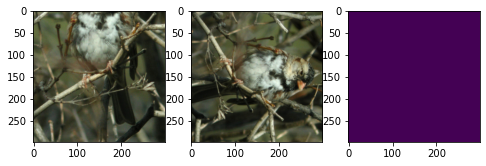

In [25]:
import matplotlib.pyplot as plt
i = 1
img = c1[i].cpu()
mask = c2[i].cpu()
img0 = im[0][i].cpu()
# print(img[i].min(), img[i].max())
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,3,1)
plt.imshow((img0.numpy().transpose((1,2,0)) - img0.min().numpy()) / (img0.max() - img0.min()).numpy())
fig.add_subplot(1,3,2)
plt.imshow((img.numpy().transpose((1,2,0)) - img.min().numpy()) / (img.max() - img.min()).numpy())
fig.add_subplot(1,3,3)
plt.imshow(mask.numpy().astype(int))
plt.show()

In [26]:
# i = 0
cap0 = a[i]
cap = c3[i]
cap_m = c4[i]
print(cap0)
print(cap[~cap_m])
print(birdtk.decode(cap, skip_special_tokens=True))
print(birdtk.decode(cap0, skip_special_tokens=True))
# print(cap_m)

tensor([4341, 4217,  907, 3066, 2074, 1946, 1902, 3484, 3973, 4472,   81, 1946,
        1902, 2929,  793], device='cuda:0')
tensor([5450, 4341, 4217,  907, 3066, 2074, 1946, 1902, 3484, 3973, 4472,   81,
        1946, 1902, 2929,  793,    0], device='cuda:0')
this bird has a black and white breast an orange bill and white eye rings
this bird has a black and white breast an orange bill and white eye rings


## Visualize CATR dataloader

In [4]:
## check the output from catr dataloader. 
from catr.cfg_damsm_cub import Config
config = Config()
dataset_train = coco.build_dataset_cub(config, mode='training')
print(f"Train: {len(dataset_train)}")
dataset_val = coco.build_dataset_cub(config, mode='validation')
print(f"Test: {len(dataset_val)}")

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, config.batch_size, drop_last=True
)

data_loader_train = DataLoader(
    dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                             sampler=sampler_val, drop_last=False)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Train: 88550
Test: 29330


In [4]:
dt2 = iter(data_loader_train).next()

In [5]:
im, ma, ca, ca_m = dt2

In [6]:
print(im.shape)
print(ma.shape)
print(ca.shape)
print(ca_m.shape)

torch.Size([32, 3, 299, 299])
torch.Size([32, 299, 299])
torch.Size([32, 129])
torch.Size([32, 129])


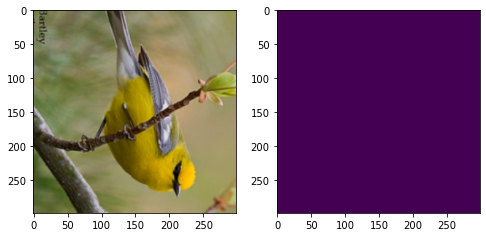

tensor([5450, 4341, 2969, 4217,  907, 3066,  964, 1913,  935,   12, 2622, 4846,
        3824,    0])
this particular bird has a belly that is yellow with gray wings


In [11]:
import matplotlib.pyplot as plt
i = 4
img = im[i].cpu()
mask = ma[i].cpu()
# img0 = im[0][i].cpu()
# print(img[i].min(), img[i].max())
fig = plt.figure(figsize=(8, 8))
# fig.add_subplot(1,2,1)
# plt.imshow((img0.numpy().transpose((1,2,0)) - img0.min().numpy()) / (img0.max() - img0.min()).numpy())
fig.add_subplot(1,2,1)
plt.imshow((img.numpy().transpose((1,2,0)) - img.min().numpy()) / (img.max() - img.min()).numpy())
fig.add_subplot(1,2,2)
plt.imshow(mask.numpy().astype(int))
plt.show()

# i = 7
cap = ca[i]
cap_m = ca_m[i]
# print(cap0)
print(cap[~cap_m])
print(birdtk.decode(cap, skip_special_tokens=True))